<a href="https://colab.research.google.com/github/thecosta/DeepLearning/blob/master/SRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/ML-data/img_align_celeba.zip

Streaming output truncated to the last 5000 lines.
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 ex

In [ ]:
import os
os.system('mkdir data')
os.system('mv img_align_celeba data/')

0

178 218


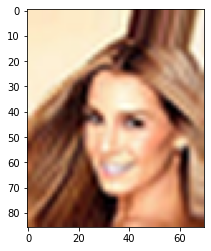

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

im = Image.open('/content/data/img_align_celeba/000001.jpg')
print(im.width, im.height)
im = im.resize((im.width//5, im.height//5), Image.ANTIALIAS)
im = im.resize((im.width*2, im.height*2), Image.ANTIALIAS)
plt.imshow(im)


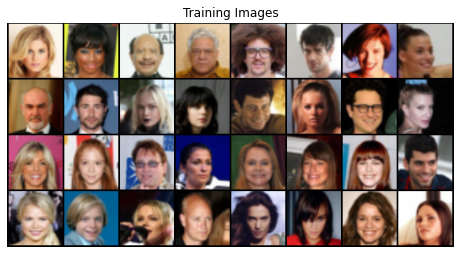

In [ ]:
import torch
import numpy as np
import torchvision.datasets as dset 
from torchvision import transforms
from torchvision import utils as vutils
dataroot = '/content/data/'
width = 178
height = 218
image_size = 64
batch_size = 32
ngpu = 1

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize((height//4, width//4)),
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
"""
Generator Network
"""
import copy
from torch import nn
from torchsummary import summary


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, 9, 1, padding='same'),
        nn.PReLU()
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(64, 64, 3, 1, padding='same'),
        nn.BatchNorm2d(64)
    )
    self.conv3 = nn.Conv2d(64, 3, 9, 1, padding='same')

    self.b_residual_block = nn.Sequential(
      nn.Conv2d(64, 64, 3, 1, padding='same'),
      nn.BatchNorm2d(64),
      nn.PReLU()
    )

    self.pixel_shuffle = nn.Sequential(
      nn.Conv2d(64, 256, 3, 1, padding='same'),
      nn.PixelShuffle(2),
      nn.PixelShuffle(1),
      nn.PReLU()
    )

  def forward(self, x):
    first_output = self.conv1(x)

    output = first_output
    for _ in range(5):
      y = copy.deepcopy(self.b_residual_block)(output)
      y += output
      output = y
    
    y = self.conv2(y)
    y += first_output

    for _ in range(2):
      y = copy.deepcopy(self.pixel_shuffle)(y)
    
    y = self.conv3(y)
    return y

netG = Generator().to(device)

netG.apply(weights_init)
#noise = torch.randn((1, 3, 128, 128)).float()
#output = netG(noise.to(device))

summary(netG.cuda(), (3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]          15,616
             PReLU-2           [-1, 64, 64, 64]               1
            Conv2d-3           [-1, 64, 64, 64]          36,928
       BatchNorm2d-4           [-1, 64, 64, 64]             128
             PReLU-5           [-1, 64, 64, 64]               1
            Conv2d-6           [-1, 64, 64, 64]          36,928
       BatchNorm2d-7           [-1, 64, 64, 64]             128
             PReLU-8           [-1, 64, 64, 64]               1
            Conv2d-9           [-1, 64, 64, 64]          36,928
      BatchNorm2d-10           [-1, 64, 64, 64]             128
            PReLU-11           [-1, 64, 64, 64]               1
           Conv2d-12           [-1, 64, 64, 64]          36,928
      BatchNorm2d-13           [-1, 64, 64, 64]             128
            PReLU-14           [-1, 64,

In [ ]:
"""
Discriminator Network
"""

class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, 3, 1, padding='same'),
        nn.LeakyReLU()
    )

    self.linear = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512*7*7, 1024),
        nn.LeakyReLU(),
        nn.Linear(1024, 1),
        nn.Sigmoid()
    )

    self.b_residual_block_1_64 = self.b_residual_block_1(64, 64)
    self.b_residual_block_1_128 = self.b_residual_block_1(64, 128)
    self.b_residual_block_2_128 = self.b_residual_block_2(128, 128)
    self.b_residual_block_1_256 = self.b_residual_block_1(128, 256)
    self.b_residual_block_2_256 = self.b_residual_block_2(256, 256)
    self.b_residual_block_1_512 = self.b_residual_block_1(256, 512)
    self.b_residual_block_2_512 = self.b_residual_block_2(512, 512)

  def b_residual_block_1(self, in_features, out_features):
    return nn.Sequential(
        nn.Conv2d(in_features, out_features, 3, 1, padding='same'),
        nn.BatchNorm2d(out_features),
        nn.LeakyReLU()
    )

  def b_residual_block_2(self, in_features, out_features):
    return nn.Sequential(
        nn.Conv2d(in_features, out_features, 3, 2),
        nn.BatchNorm2d(out_features),
        nn.LeakyReLU()
    )

  def forward(self, x):
    y = self.conv1(x)
    y = self.b_residual_block_1_64(y)

    y = self.b_residual_block_1_128(y)
    y = self.b_residual_block_2_128(y)

    y = self.b_residual_block_1_256(y)
    y = self.b_residual_block_2_256(y)

    y = self.b_residual_block_1_512(y)
    y = self.b_residual_block_2_512(y)
    
    y = self.linear(y)
    print(y.shape)
    return y

netD = Discriminator().to(device)
#print(netD)
summary(netD.cuda(), (3, 64, 64))
netD.apply(weights_init)
#noise = torch.randn((1, 3, 128, 128)).float()
#output = netD(noise.to(device))
#print(output.shape)


torch.Size([2, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
       BatchNorm2d-4           [-1, 64, 64, 64]             128
         LeakyReLU-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
       BatchNorm2d-7          [-1, 128, 64, 64]             256
         LeakyReLU-8          [-1, 128, 64, 64]               0
            Conv2d-9          [-1, 128, 31, 31]         147,584
      BatchNorm2d-10          [-1, 128, 31, 31]             256
        LeakyReLU-11          [-1, 128, 31, 31]               0
           Conv2d-12          [-1, 256, 31, 31]         295,168
      BatchNorm2d-13          [-1, 256, 31, 31]             512
        LeakyReLU-14

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=25088, out_features=1024, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=1024, out_features=1, bias=True)
    (4): Sigmoid()
  )
  (b_residual_block_1_64): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (b_residual_block_1_128): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (b_residual_block_2_128): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2

In [ ]:
import torch.optim as optim 
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 64, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
torch.cuda.empty_cache()
del real_cpu


In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
b_size = 64

save_path = '/content/gdrive/MyDrive/ML-data/srgan/'
print("Starting Training Loop...")
# For each epoch
for epoch in range(20):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 3, 64, 64, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        print(fake.shape)
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    save_checkpoint = os.path.join(save_path, f'ckpt-{epoch}-{np.mean(D_losses):.2f}-{np.mean(G_losses):.2f}')
    os.system(f'mkdir {save_checkpoint}')
    print(f'Saving to... {save_checkpoint}')
    torch.save(netD, os.path.join(save_checkpoint, 'discriminator.pt'))
    torch.save(netG, os.path.join(save_checkpoint, 'generator.pt'))


Starting Training Loop...
torch.Size([32, 1])
torch.Size([32, 3, 256, 256])


RuntimeError: ignored

# Test out DCGAN Generator

In [ ]:
import pickle
with open('/content/gdrive/MyDrive/ML-data/dcgan/images.pkl', 'rb') as f:
  images = pickle.load(f)

In [ ]:
from torch import nn
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
g = torch.load('/content/gdrive/MyDrive/ML-data/dcgan/ckpt-9-0.69-3.02/generator.pt')

torch.Size([64, 100, 1, 1])
torch.Size([64, 3, 64, 64])


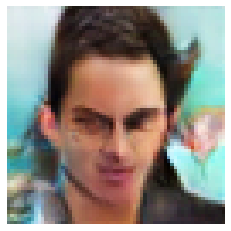

In [ ]:
import torchvision
import matplotlib.animation as animation
from IPython.display import HTML
img = torchvision.io.read_image('/content/gdrive/MyDrive/ML-data/dcgan/propic.jpg')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_device = img.to(device)

transform = torch.nn.Sequential(
    transforms.Resize([64, 100])
)

image_transform = transform(img_device)
image_transform = image_transform[0, :, :, None, None]
image_transform = image_transform.to(device)
print(image_transform.shape)

fake = g(image_transform.float()).detach().cpu()
print(fake.shape)
fig = plt.figure(figsize=(4,4))
plt.axis("off")

ims = [[plt.imshow(np.transpose(vutils.make_grid(i, padding=2, normalize=True),(1,2,0)), animated=True)] for i in fake]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())